### Look at Tallo and BAAD for species in FATES-MRV projects

#### Libraries 

In [1]:
import numpy as np
import xarray as xr
import csv
import pandas as pd

import functions_py.fates_xarray_functions as fa

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cartopy.crs as ccrs
from matplotlib import cm

import math as m
from scipy.optimize import curve_fit
from scipy.stats import linregress

### Read in Tallo and BAAD data

In [2]:
# Note these dataframes were processed in the notebook  v2_Tallo_analysis_global.ipynb
df_tallo = pd.read_csv('/pscratch/sd/j/jneedham/trait_data/df_tallo.csv')
df_baad = pd.read_csv('/pscratch/sd/j/jneedham/trait_data/df_baad.csv')


In [3]:
print(df_tallo.head(3))
#  remove rows with NA for species
df_tallo = df_tallo.dropna(subset=['species'])

            species  latitude  longitude   dbh  height height_outlier  \
0  Betula pubescens    67.395     28.723  10.0     5.6              N   
1       Picea abies    67.395     28.723  10.0     6.6              N   
2       Picea abies    67.395     28.723  10.0     8.5              N   

   crown_radius_m crown_radius_outlier                       PFT_tallo  \
0            1.65                    N             broadleaf_extratrop   
1            0.85                    N  needleleaf_evergreen_extratrop   
2            0.75                    N  needleleaf_evergreen_extratrop   

   crown_area  
0    8.552986  
1    2.269801  
2    1.767146  


### USA

#### Hybrid Populus tremula × Populus alba

In [4]:
# find the two 'parent' species
populus_alba = df_tallo[df_tallo['species'].str.contains('Populus alba', case=False)]
populus_tremula = df_tallo[df_tallo['species'].str.contains('Populus tremula', case=False)]

populus = pd.concat([populus_alba, populus_tremula], axis=0)

In [5]:
def d2hmc (d, p1, p2, p3) :
    h = (p1 * d**p2) / (p3 + d**p2)
    return h

initial_guess = [58.0, 0.73, 21.8]


In [6]:
pop_h =  populus.dropna(subset=['height', 'dbh'])
# remove outliers
pop_h = pop_h[pop_h['height_outlier'] == 'N']
pop_h = pop_h[pop_h['dbh'] < 100]
dbh_pop_h = np.arange(1,pop_h['dbh'].max(),1)

height_ps_pop, height_cov_pop = curve_fit(f=d2hmc, xdata=np.array(pop_h['dbh']), ydata=np.array(pop_h['height']),
                                           p0=initial_guess)
pop_curve_h = [d2hmc(d, height_ps_pop[0], height_ps_pop[1], height_ps_pop[2])  for  d  in dbh_pop_h]

palba_h = pop_h[pop_h['species']  ==  'Populus alba']
ptrem_h = pop_h[pop_h['species']  ==  'Populus tremula']

print(height_ps_pop)

[30.84653668  1.10525761 18.05775934]


In [7]:
def d2ca (d, p1) :
    ca = d ** p1
    return ca

In [8]:
pop_ca = populus.dropna(subset=['crown_area','dbh'])
# remove outliers
pop_ca = pop_ca[pop_ca['crown_radius_outlier'] == 'N']
pop_ca = pop_ca[pop_ca['dbh'] < 100]
dbh_pop_ca = np.arange(1,pop_ca['dbh'].max(),1)

ca_ps_pop, ca_cov_pop = curve_fit(f=d2ca, xdata=np.array(pop_ca['dbh']), ydata=np.array(pop_ca['crown_area']), p0=1.3)

pop_curve_ca = [d2ca(d, ca_ps_pop[0])  for  d  in dbh_pop_ca]
palba_ca = pop_ca[pop_ca['species']  ==  'Populus alba']
ptrem_ca = pop_ca[pop_ca['species']  ==  'Populus tremula']

print(ca_ps_pop)

[1.00515389]


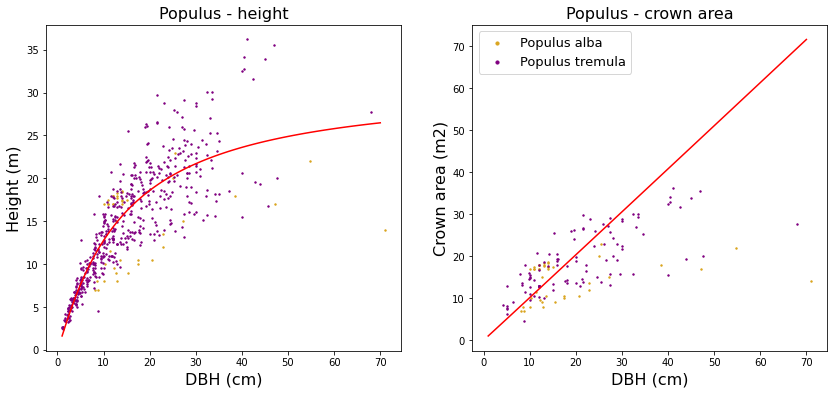

In [16]:
fig, ((fax0,fax1)) = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

fax0.scatter(palba_h.dbh, palba_h.height, c='goldenrod', s=2, label = 'Populus alba')
fax0.scatter(ptrem_h.dbh, ptrem_h.height, c='purple', s=2, label = 'Populus tremula')
fax0.plot(dbh_pop_h, pop_curve_h, color='red')
fax0.set_title('Populus - height', fontsize=16)
fax0.set_ylabel('Height (m)', fontsize=16)
fax0.set_xlabel('DBH (cm)', fontsize=16)

    
fax1.scatter(palba_ca.dbh, palba_ca.height, c='goldenrod', s=2, label = 'Populus alba')
fax1.scatter(ptrem_ca.dbh, ptrem_ca.height, c='purple', s=2, label = 'Populus tremula')
fax1.plot(dbh_pop_ca, pop_curve_ca, color='red')
fax1.set_title('Populus - crown area', fontsize=16)
fax1.set_ylabel('Crown area (m2)', fontsize=16)
fax1.set_xlabel('DBH (cm)', fontsize=16)
fax1.legend(fontsize=13)    

# Get the legend object
legend = fax1.get_legend()
for legobj in legend.legendHandles:
    legobj.set_sizes([10])
    
plt.savefig('/global/homes/j/jneedham/jupyter_notebooks/mrv_figs/Populus_CA_height.png', facecolor='white')    

### Get the wood  density of populus - mean of the two species
These species aren't  in BAAD so we can't get AGB parameters 

In [33]:
df_wd = pd.read_csv('/pscratch/sd/j/jneedham/trait_data/wood_density_utf8.csv')

# remove the outlier
max_index = df_wd['wood_dens'].idxmax()
print(df_wd.loc[max_index])

df_wd = df_wd[df_wd['wood_dens'] < 20.0]

df_wd_mean = df_wd.groupby('ScientificName')['wood_dens'].mean().reset_index()
print(df_wd_mean.head(4))

ScientificName    Cecropia glaziovii
wood_dens                      22.15
Name: 49328, dtype: object
            ScientificName  wood_dens
0  ARCTOSTAPHYLOS UVA-URSI   0.515767
1       Abarema adenophora   0.511729
2      Abarema barbouriana   0.418682
3    Abarema brachystachya   0.537852


In [34]:
# populus wd
pop_alba_wd = df_wd_mean[df_wd_mean['ScientificName'].str.contains('Populus alba', case=False)]
pop_trem_wd = df_wd_mean[df_wd_mean['ScientificName'].str.contains('Populus tremula', case=False)]

print(pop_alba_wd)
print(pop_trem_wd)

pop_wd = np.mean([pop_alba_wd.wood_dens, pop_trem_wd.wood_dens])

print(pop_wd)

     ScientificName  wood_dens
8404   Populus alba   0.419722
       ScientificName  wood_dens
8432  Populus tremula   0.522682
0.4712021328783584


### For the remaining species filter by east coast of USA and get deciduous broadleaf and evergreen needleleaf

###  Mexico

####  Oaks 

In [35]:
quercus = df_tallo[df_tallo['species'].str.contains('Quercus', case=False)]
print(quercus.head(3))
print(len(quercus))

                 species  latitude  longitude  dbh  height height_outlier  \
1813      Quercus kerrii    18.617    108.951  3.0     5.0              N   
1898  Quercus macrocalyx    18.683    108.876  3.0     4.5              N   
2020    Quercus auricoma    18.731    109.867  3.0     7.0              N   

      crown_radius_m crown_radius_outlier           PFT_tallo  crown_area  
1813             0.5                    N  broadleaf_tropical    0.785398  
1898             0.6                    N  broadleaf_tropical    1.130973  
2020             0.6                    N  broadleaf_tropical    1.130973  
69107


Text(0.5, 1.0, 'Quercus')

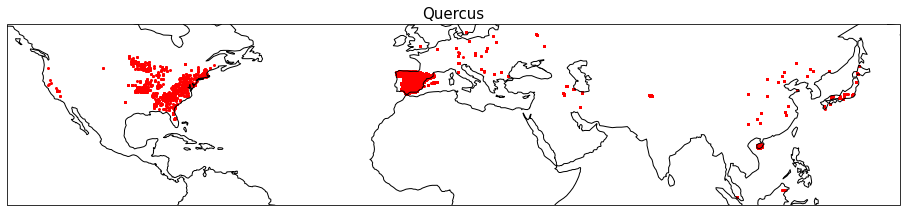

In [36]:
fig1, ((f1ax0)) = plt.subplots(nrows=1, ncols=1,  subplot_kw={'projection': ccrs.PlateCarree()},
                                                   figsize=(16,6))

f1ax0.scatter(quercus.longitude, quercus.latitude, color='red', s=4, marker='o', transform=ccrs.PlateCarree())
f1ax0.coastlines()
f1ax0.set_title('Quercus', fontsize=15)

Text(0.5, 1.0, 'All species')

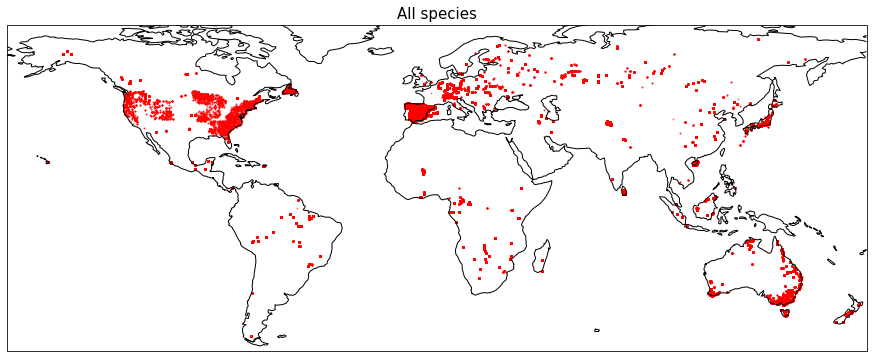

In [15]:
fig1, ((f1ax0)) = plt.subplots(nrows=1, ncols=1,  subplot_kw={'projection': ccrs.PlateCarree()},
                                                   figsize=(16,6))

f1ax0.scatter(df_tallo.longitude, df_tallo.latitude, color='red', s=1, marker='o',  alpha=0.4, transform=ccrs.PlateCarree())
f1ax0.coastlines()
f1ax0.set_title('All species', fontsize=15)

In [ ]:
df_tallo_mx  = df_tallo[df_tallo['latitude'] 